In [1]:
# Unfortunately since the analysis is very specific (at the moment)
# We don't offer the ability to read your own (X,y) and place into .fit(...) method
#    (the usual behavior) 

# Instead you must call .fit( ) with some other hyper-params, and the code will read in the relevant
# sensors for you, and re-arrange them appropriately.

# This notebook is designed to clarify how to work with these functions

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
data_path = os.path.abspath(os.path.join('..\\data\\sensor_data')) + '\\'
    
from modules.timeSeriesModels.TimeSeriesAnalysis import TensorDecomp, MatrixProfile, ChangePoint 

## Tensor Decomposition

I will write something high level here

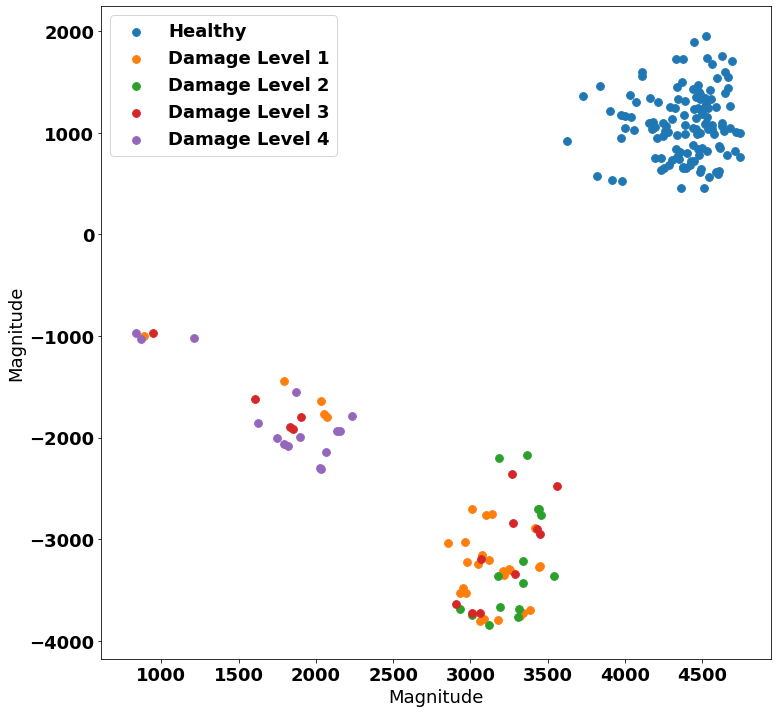

In [2]:
TD = TensorDecomp(num_dims=2, data_path=data_path)

TD.fit(data_type='Building', sensor_nums=[1,2,3,4,5])

TD.plot()

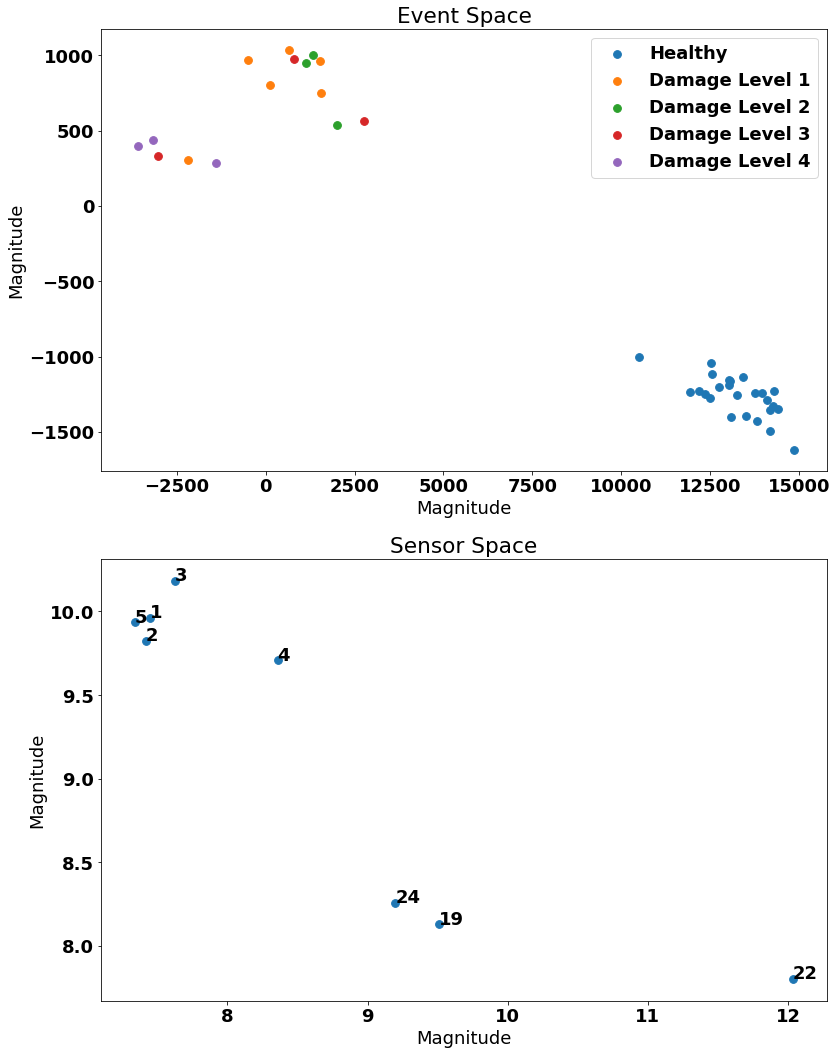

In [3]:
TD = TensorDecomp(num_dims=3, data_path=data_path)

TD.fit(data_type='Building', sensor_nums=[1,2,3,4,5,22,24,19])

TD.plot()

As can be seen below, aircraft data is low cardinality so tensor decomposition (whilst great for building), can suffer in such situations. There is still useful information (e.g. observe sensor groupings in 3D decomp.), but you loose a lot of shape information of the time series which is critical when there is a lack of "events"

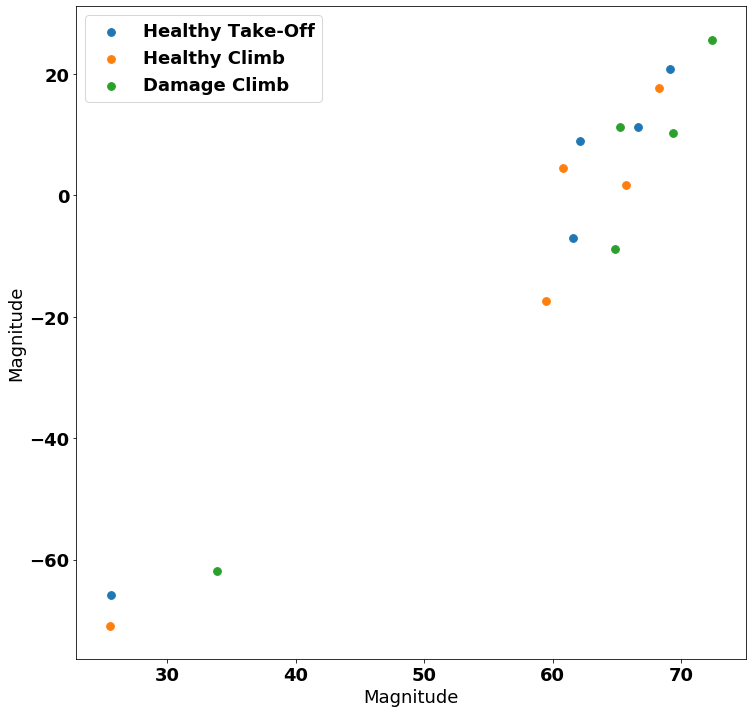

In [4]:
TD = TensorDecomp(num_dims=2, data_path=data_path)

TD.fit(data_type='Aircraft', sensor_nums=[1,2,3,4,5])

TD.plot()

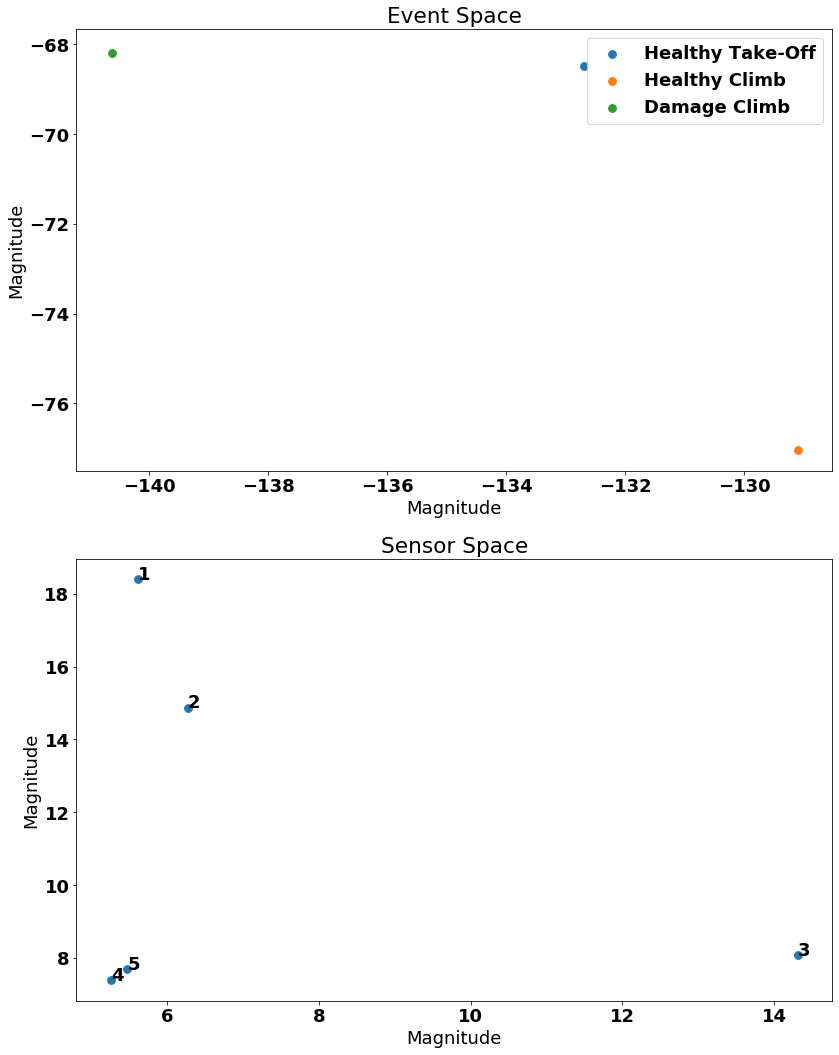

In [5]:
TD = TensorDecomp(num_dims=3, data_path=data_path)

TD.fit(data_type='Aircraft', sensor_nums=[1,2,3,4,5])

TD.plot()

C:\ProgramData\Anaconda3\lib\site-packages\stumpy\aamp.py:193: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  ndist_counts = core._count_diagonal_ndist(diags, m, n_A, n_B)


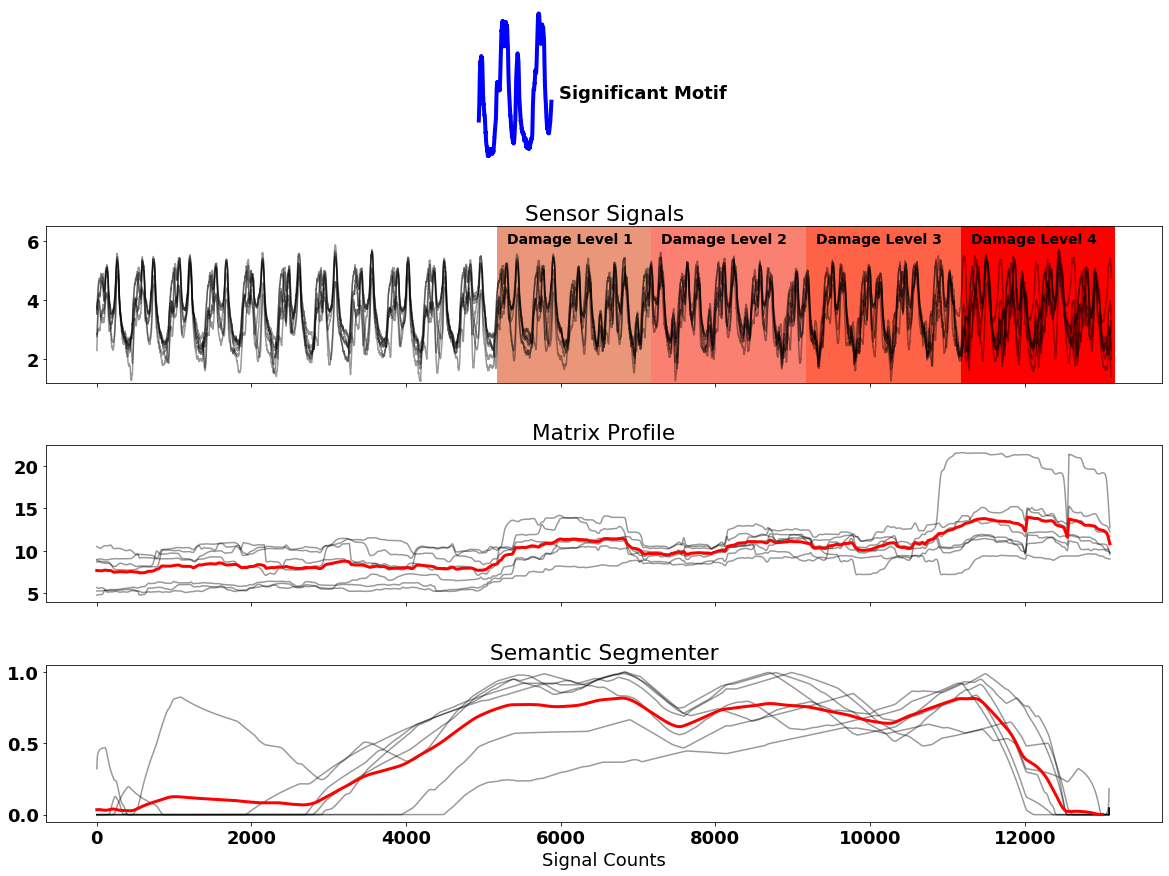

In [6]:
MP = MatrixProfile(data_path=data_path)

MP.fit(data_type = 'Building', sensor_nums = [4,2,5,7,9,23,21])

MP.plot()

Observe the difference in matrix profiling with and without sensor 3 (criticial sensor for this context). Semantic segmentor picks up change in flight phase as something anamolous ... false alarm!

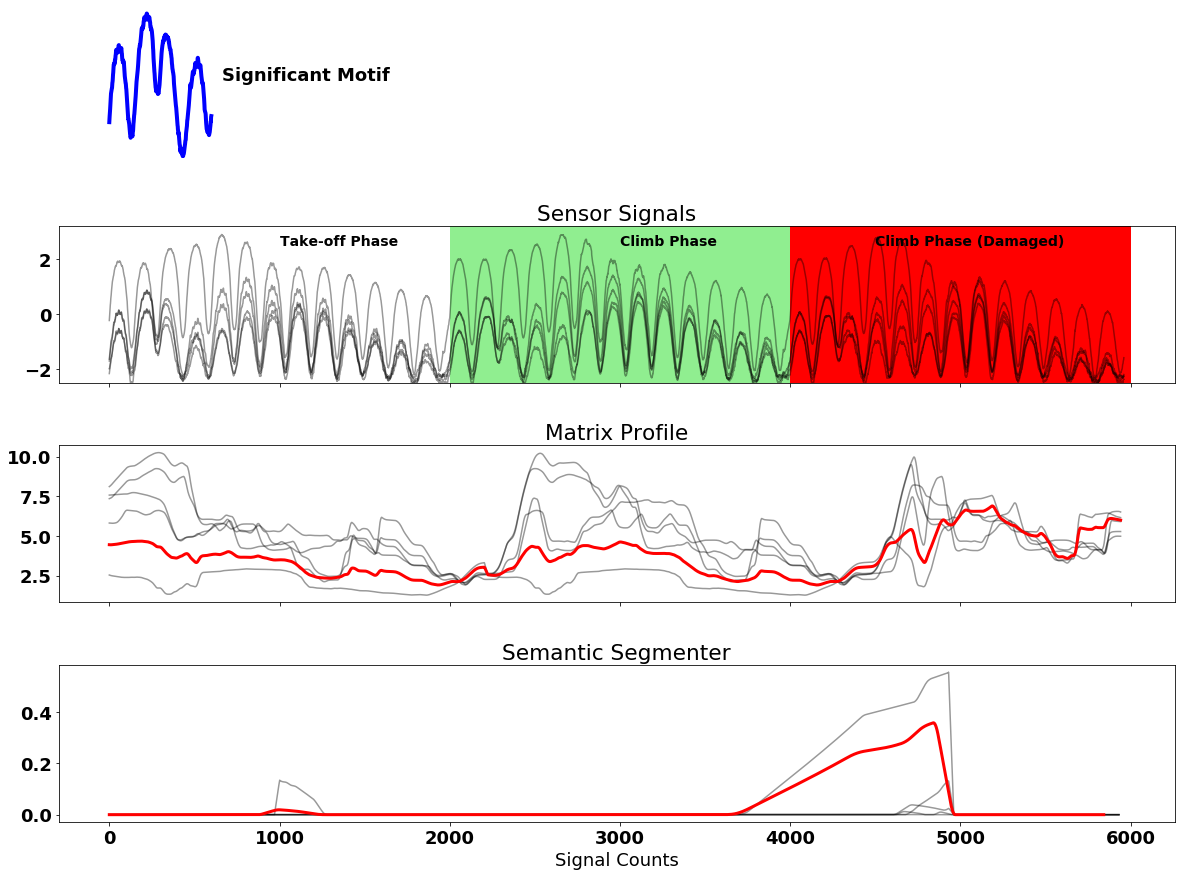

In [7]:
MP = MatrixProfile(data_path=data_path)

MP.fit(data_type = 'Aircraft', sensor_nums = [1,2,3,4,5])

MP.plot()

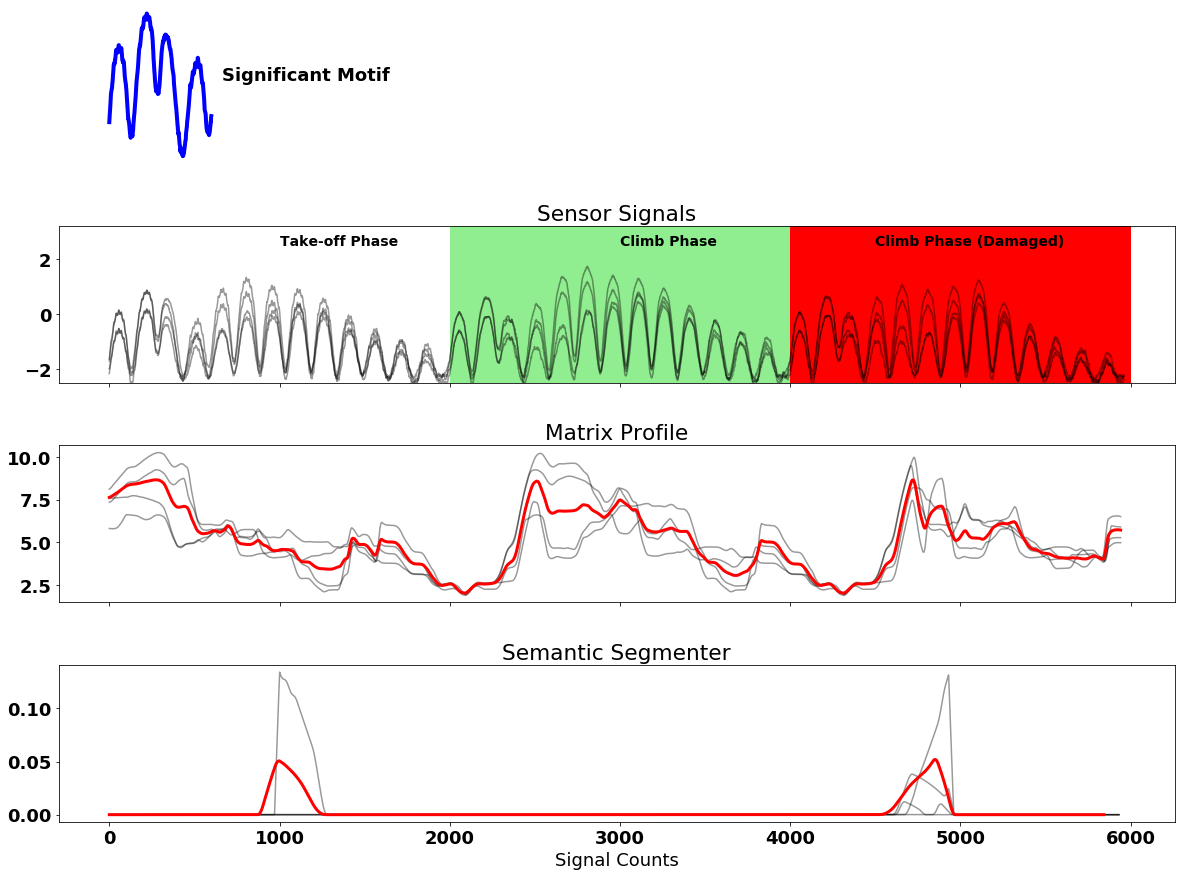

In [8]:
MP = MatrixProfile(data_path=data_path)

MP.fit(data_type = 'Aircraft', sensor_nums = [1,2,4,5])

MP.plot()

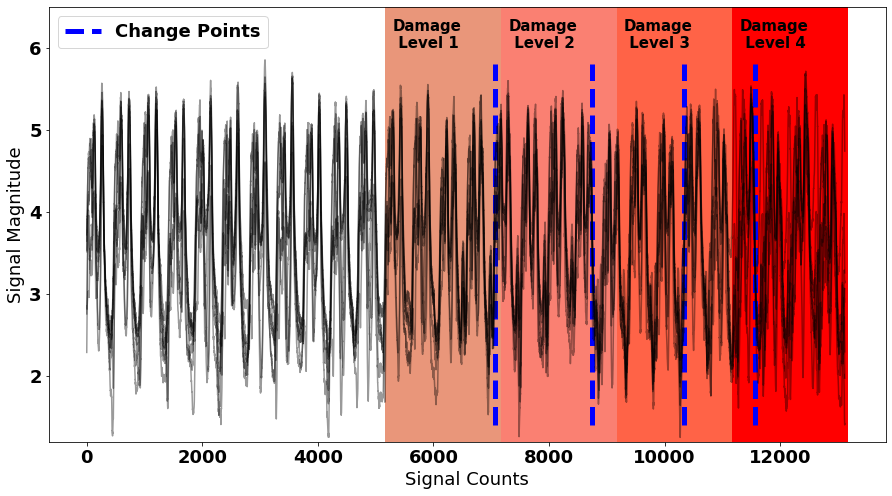

In [9]:
CP = ChangePoint(data_path=data_path)

CP.fit(data_type = 'Building', sensor_nums = [4,2,5,7,9,23,21])

CP.plot()

Notice change point analyzer tends to put too many change points (and lag them by too much), when not enough sensors are used. Therefore, more sensors ==> better analysis. Of course!  

However, it seems even if all five sensors are used, the climb phase damage is still detected too late. Perhaps either better (i) Pre-processing needed, (ii) Better ensembling, (iii) More data+sensors

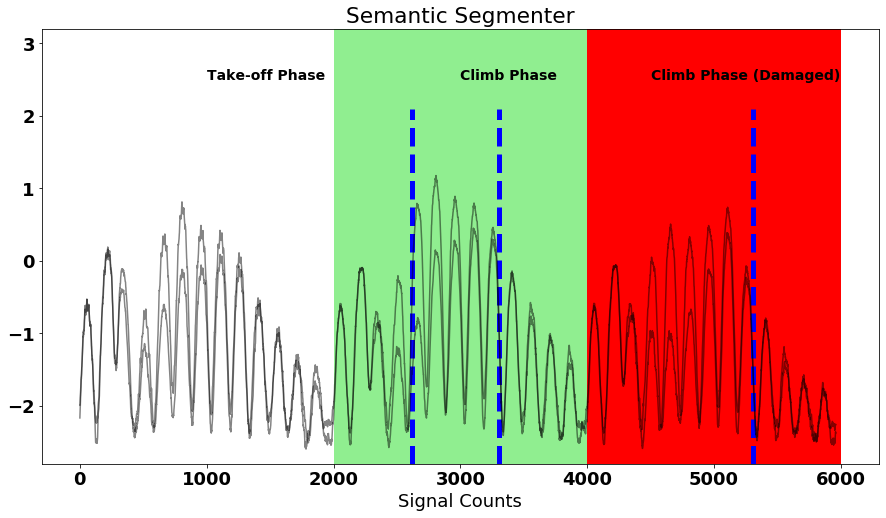

In [10]:
CP = ChangePoint(data_path=data_path)

CP.fit(data_type = 'Aircraft', sensor_nums = [4,5])

CP.plot()

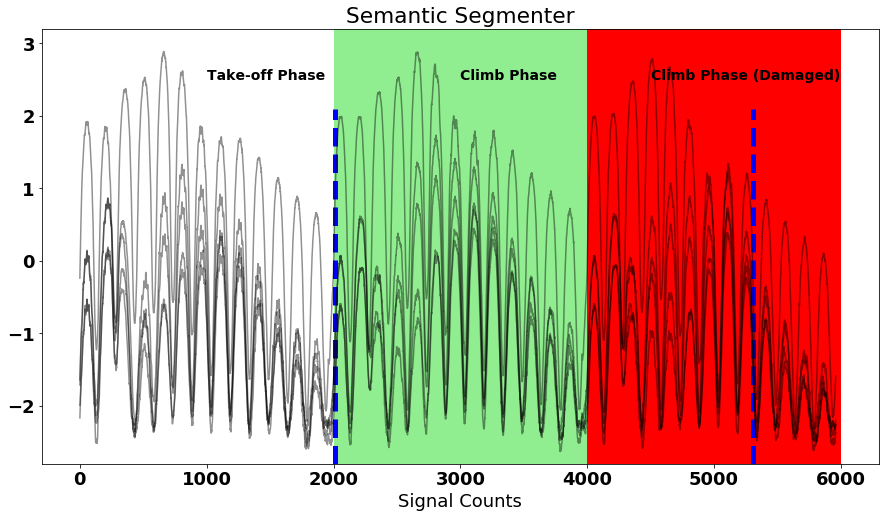

In [11]:
CP = ChangePoint(data_path=data_path)

CP.fit(data_type = 'Aircraft', sensor_nums = [1,2,3,4,5])

CP.plot()